based on mfrpred_mreiss_bz.ipynb for Bz prediction

In [14]:
#import os
#import sys
#import time
#import copy

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import cm
import numpy as np
import pickle
from scipy import stats
import scipy.io
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix



# Machine learning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import ElasticNet, HuberRegressor, Lars, LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor, RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Don't print warnings
import warnings
warnings.filterwarnings('ignore')

print('Versions')

print(np.__version__)#==1.17.2
print(matplotlib.__version__)#3.1.2
print(scipy.__version__)#1.3.1
print(pd.__version__)#0.25.3
import sklearn
print(sklearn.__version__)#0.20.3
print(sns.__version__)#0.9.0
import PIL
print(PIL.__version__)#8.1.2

Versions
1.20.3
3.4.2
1.6.3
1.2.4
0.24.2
0.11.1
8.2.0


In [20]:
# Make plots and results folders
mfrdir = 'mfr_predict'
if os.path.isdir(mfrdir) == False: 
    os.mkdir(mfrdir)

plotdir = 'mfr_plots'
if os.path.isdir(plotdir) == False: 
    os.mkdir(plotdir)
    
# File names to save features into
savepath_win = 'wind_features.p'
savepath_sta = 'sta_features.p'
savepath_stb = 'stb_features.p'

In [21]:
[ic,header,parameters] = pickle.load(open('../data_mfr/HELCATS_ICMECAT_v20_pandas.p', "rb" ))

# Spacecraft
isc = ic.loc[:,'sc_insitu'] 

# Shock arrival or density enhancement time
icme_start_time = ic.loc[:,'icme_start_time']
icme_start_time_num = date2num(np.array(icme_start_time))

# Start time of the magnetic obstacle (mo)
mo_start_time = ic.loc[:,'mo_start_time']
mo_start_time_num = date2num(np.array(mo_start_time))

# End time of the magnetic obstacle (mo)
mo_end_time = ic.loc[:,'mo_end_time']
mo_end_time_num = date2num(np.array(mo_end_time))

#get indices for each target
wini=np.where(ic.sc_insitu=='Wind')[0]
stai=np.where(ic.sc_insitu=='STEREO-A')[0]
stbi=np.where(ic.sc_insitu=='STEREO-B')[0]
pspi=np.where(ic.sc_insitu=='PSP')[0]
soloi=np.where(ic.sc_insitu=='SolarOrbiter')[0]
bepii=np.where(ic.sc_insitu=='BepiColombo')[0]
ulyi=np.where(ic.sc_insitu=='Ulysses')[0]
messi=np.where(ic.sc_insitu=='Messenger')[0]
vexi=np.where(ic.sc_insitu=='VEX')[0]

In [22]:
ic

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_Wind_MOESTL_20210311_01,Wind,2021-03-11 21:40:00,2021-03-11 21:40:00,2021-03-12 09:26:00,0.9838,0.24,-7.28,11.77,9.5,...,4.2,0.2,13010.2,4965.5,NaN,NaN,NaN,NaN,NaN,NaN
1,ICME_SOLO_MOESTL_20201119_01,SolarOrbiter,2020-12-19 20:39:00,2020-12-20 10:15:00,2020-12-21 04:30:00,0.7682,125.87,-3.05,31.85,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ICME_STEREO_A_MOESTL_20201203_01,STEREO-A,2020-12-03 18:04:00,2020-12-03 22:19:00,2020-12-04 02:14:00,0.9596,-57.48,6.41,8.17,11.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ICME_STEREO_A_MOESTL_20201201_01,STEREO-A,2020-12-01 07:28:00,2020-12-01 10:17:00,2020-12-01 18:30:00,0.9594,-57.60,6.57,11.03,15.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ICME_PSP_MOESTL_20201201_01,PSP,2020-12-01 02:22:00,2020-12-01 03:13:00,2020-12-01 08:34:00,0.8037,-96.85,3.77,6.20,49.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,ICME_VEX_SGOOD_20070213_01,VEX,2007-02-13 14:40:00,2007-02-13 14:40:00,2007-02-14 09:33:00,0.7245,-117.25,2.83,18.88,19.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
774,ICME_Wind_NASA_20070115_01,Wind,2007-01-15 20:49:00,2007-01-15 20:49:00,2007-01-16 04:45:00,0.9731,0.15,-4.57,7.93,10.4,...,4.1,1.4,97358.1,37602.1,NaN,NaN,NaN,NaN,NaN,NaN
775,ICME_STEREO_B_JIAN_20070114_01,STEREO-B,2007-01-14 12:24:00,2007-01-14 13:59:00,2007-01-15 07:37:00,0.9791,0.02,-4.52,19.22,14.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
776,ICME_STEREO_A_JIAN_20070114_01,STEREO-A,2007-01-14 12:11:00,2007-01-14 14:39:00,2007-01-15 07:34:00,0.9727,0.26,-4.61,19.38,14.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Load Wind data
[win, winheader] = pickle.load(open("../data_mfr/wind_2007_2021_heeq_ndarray.p", "rb"))

# Load STEREO-A data
[sta, atta] = pickle.load(open("../data_mfr/stereoa_2007_2021_sceq_ndarray.p", "rb"))

# Load STEREO-B data
[stb, attb, stbheader] = pickle.load(open("../data_mfr/stereob_2007_2014_sceq_ndarray.p", "rb"))

#with new matplotlib version, convert to new date format

win['time']=win['time']+date2num(np.datetime64('0000-12-31'))
sta['time']=sta['time']+date2num(np.datetime64('0000-12-31'))
stb['time']=stb['time']+date2num(np.datetime64('0000-12-31'))




In [24]:
# Event indices from STEREO and Wind
istaind = np.where(isc == 'STEREO-A')[0]
istbind = np.where(isc == 'STEREO-B')[0]
iwinind = np.where(isc == 'Wind')[0]

# Event indices where the start time of the CME does not match the start time of the magnetic obstacle
n_iwinind = np.where(icme_start_time_num[iwinind] != mo_start_time_num[iwinind])[0]
n_istaind = np.where(icme_start_time_num[istaind] != mo_start_time_num[istaind])[0]
n_istbind = np.where(icme_start_time_num[istbind] != mo_start_time_num[istbind])[0]

# Correct indicies to take from all data, not just subset
i_icme_start_time_num = np.arange(len(icme_start_time_num))
n_iwinind = i_icme_start_time_num[iwinind][n_iwinind]
n_istaind = i_icme_start_time_num[istaind][n_istaind]
n_istbind = i_icme_start_time_num[istbind][n_istbind]

# Count the number of selected events
print("Events with a sheath region in WIND    : {} / {}".format(n_iwinind.shape[0], iwinind.shape[0]))   # TODO
print("Events with a sheath region in STEREO-A: {} / {}".format(n_istaind.shape[0], istaind.shape[0]))
print("Events with a sheath region in STEREO-B: {} / {}".format(n_istbind.shape[0], istbind.shape[0]))
print("Number of Events with a sheath region  :", n_iwinind.shape[0] + n_istaind.shape[0] + n_istbind.shape[0])

#indices of all selected events
n_all=np.hstack([n_iwinind,n_istaind,n_istbind])
print('percentage of all events',np.round((n_iwinind.shape[0] + n_istaind.shape[0] + n_istbind.shape[0])/ (np.size(stbi)+np.size(wini)+np.size(stai)) *100 ) )

Events with a sheath region in WIND    : 149 / 186
Events with a sheath region in STEREO-A: 135 / 222
Events with a sheath region in STEREO-B: 78 / 150
Number of Events with a sheath region  : 362
percentage of all events 65.0


In [25]:
print('for the selected events with sheath')
print()
print("Average ICME length   : {:.2f} hours".format(((mo_end_time_num[n_all] - icme_start_time_num[n_all])*24.).mean()))
print("Average MO length    : {:.2f} hours".format(((mo_end_time_num[n_all] - mo_start_time_num[n_all])*24.).mean()))
print("Average SHEATH length: {:.2f} hours".format(((mo_start_time_num[n_all] - icme_start_time_num[n_all])*24.).mean()))
print()
print("STD ICME length   : {:.2f} hours".format(((mo_end_time_num[n_all] - icme_start_time_num[n_all])*24.).std()))
print("STD MO length    : {:.2f} hours".format(((mo_end_time_num[n_all] - mo_start_time_num[n_all])*24.).std()))
print("STD SHEATH length: {:.2f} hours".format(((mo_start_time_num[n_all] - icme_start_time_num[n_all])*24.).std()))

for the selected events with sheath

Average ICME length   : 34.01 hours
Average MO length    : 25.16 hours
Average SHEATH length: 8.85 hours

STD ICME length   : 17.11 hours
STD MO length    : 14.80 hours
STD SHEATH length: 6.18 hours


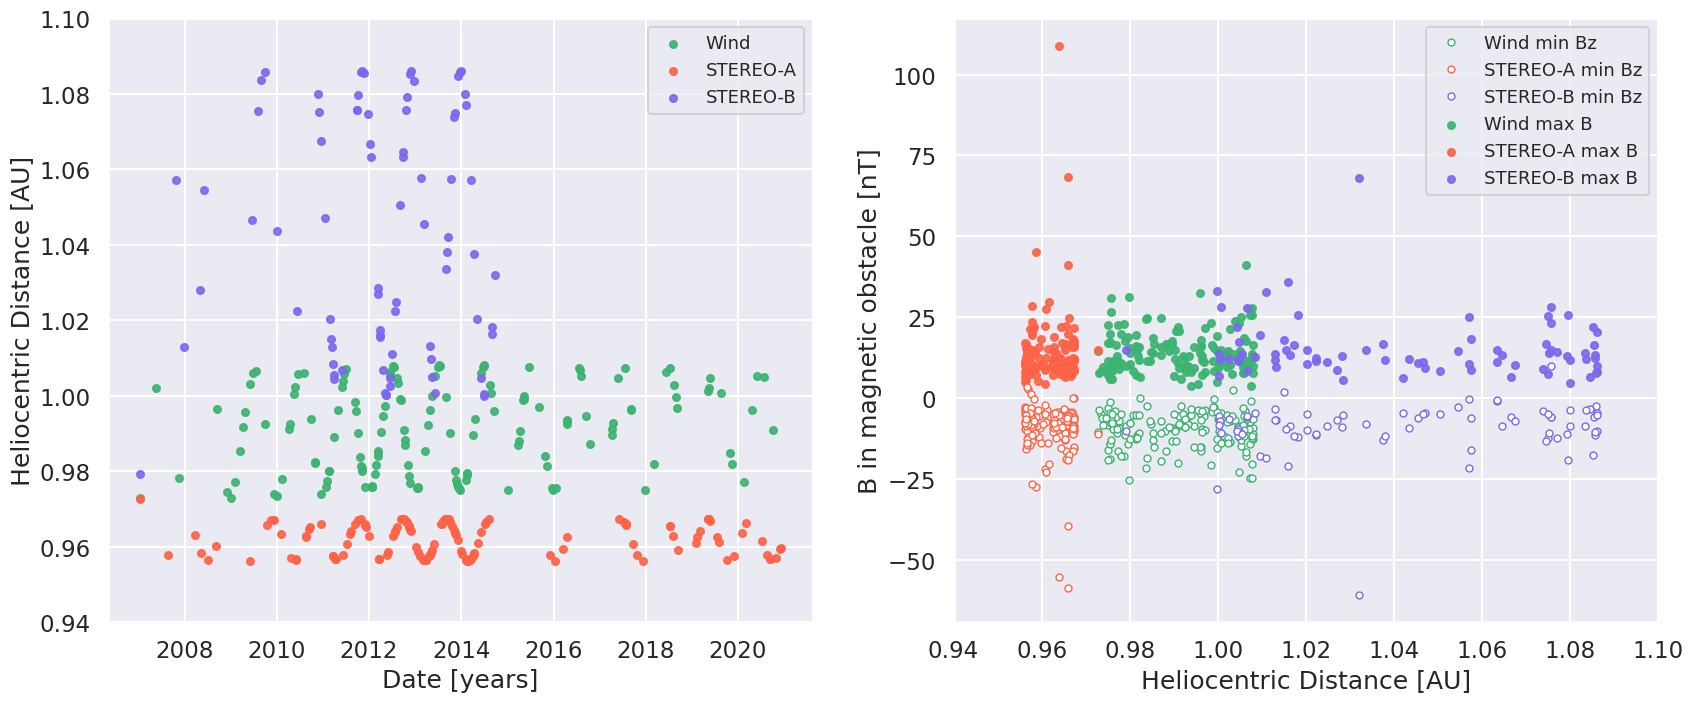

selected events with sheath
number of events: Wind,  149
number of events: STA,  135
number of events: STB,  78
total: 362


In [26]:
#markersize
ms=25
#alpha
al=0.9

sns.set_context("talk")     
sns.set_style('darkgrid')

fig=plt.figure(figsize=(20,8),dpi=100)


ax1 = plt.subplot(121) 
plt.scatter(ic.loc[n_iwinind,'icme_start_time'], ic.loc[n_iwinind,'mo_sc_heliodistance'], label='Wind', s=ms,c='mediumseagreen', alpha=al)
plt.scatter(ic.loc[n_istaind,'icme_start_time'], ic.loc[n_istaind,'mo_sc_heliodistance'], label='STEREO-A',s=ms,c='tomato', alpha=al)
plt.scatter(ic.loc[n_istbind,'icme_start_time'], ic.loc[n_istbind,'mo_sc_heliodistance'], label='STEREO-B',s=ms,c='mediumslateblue', alpha=al)
plt.ylabel('Heliocentric Distance [AU]')
plt.xlabel('Date [years]')
plt.ylim([0.94,1.1])
plt.legend(loc=1,fontsize=13)



ax2 = plt.subplot(122) 
#ax2.scatter(ic.loc[wini,'mo_sc_heliodistance'],ic.loc[wini,'mo_bmean'], label='Wind', s=ms,c='mediumseagreen', alpha=al)
#ax2.scatter(ic.loc[stai,'mo_sc_heliodistance'],ic.loc[stai,'mo_bmean'], label='STEREO-A',s=ms,c='red', alpha=al)
#ax2.scatter(ic.loc[stbi,'mo_sc_heliodistance'],ic.loc[stbi,'mo_bmean'], label='STEREO-B',s=ms,c='blue', alpha=al)

ax2.scatter(ic.loc[n_iwinind,'mo_sc_heliodistance'],ic.loc[n_iwinind,'mo_bmax'], label='Wind max B', s=ms,c='mediumseagreen', alpha=al)
ax2.scatter(ic.loc[n_istaind,'mo_sc_heliodistance'],ic.loc[n_istaind,'mo_bmax'], label='STEREO-A max B',s=ms,c='tomato', alpha=al)
ax2.scatter(ic.loc[n_istbind,'mo_sc_heliodistance'],ic.loc[n_istbind,'mo_bmax'], label='STEREO-B max B',s=ms,c='mediumslateblue', alpha=al)

al=1.0
ax2.plot(ic.loc[n_iwinind,'mo_sc_heliodistance'],ic.loc[n_iwinind,'mo_bzmin'], linestyle='None',marker='o',ms=5,c='mediumseagreen',markerfacecolor='white',label='Wind min Bz', alpha=al)
ax2.plot(ic.loc[n_istaind,'mo_sc_heliodistance'],ic.loc[n_istaind,'mo_bzmin'], linestyle='None',marker='o',ms=5,label='STEREO-A min Bz',markerfacecolor='white',c='tomato', alpha=al)
ax2.plot(ic.loc[n_istbind,'mo_sc_heliodistance'],ic.loc[n_istbind,'mo_bzmin'], linestyle='None',marker='o',ms=5, label='STEREO-B min Bz',markerfacecolor='white',c='mediumslateblue', alpha=al)


ax2.set_xlabel('Heliocentric Distance [AU]')
ax2.set_ylabel('B in magnetic obstacle [nT]')
ax2.set_xlim([0.94,1.1])
ax2.legend(loc=1,fontsize=13)




'''
ax2 = plt.subplot(122, projection='polar') 
plt.title('HELCATS ICME arrivals at targets [HEEQ longitude]')
ax2.scatter(np.radians(ic.mo_sc_long_heeq[wini]),ic.mo_sc_heliodistance[wini], label='Wind', s=ms,c='mediumseagreen', alpha=al)
ax2.scatter(np.radians(ic.mo_sc_long_heeq[stai]),ic.mo_sc_heliodistance[stai], label='STEREO-A', s=ms,c='red', alpha=al)
ax2.scatter(np.radians(ic.mo_sc_long_heeq[stbi]),ic.mo_sc_heliodistance[stbi], label='STEREO-B', s=ms,c='blue', alpha=al)
ax2.scatter(np.radians(ic.mo_sc_long_heeq[soloi]),ic.mo_sc_heliodistance[soloi], label='Others', s=ms,c='dimgrey', alpha=al)
#ax2.scatter(np.radians(ic.mo_sc_long_heeq[pspi]),ic.mo_sc_heliodistance[pspi],s=ms,c='dimgrey', alpha=al)
ax2.scatter(np.radians(ic.mo_sc_long_heeq[bepii]),ic.mo_sc_heliodistance[bepii],s=ms,c='dimgrey', alpha=al)
ax2.scatter(np.radians(ic.mo_sc_long_heeq[ulyi]),ic.mo_sc_heliodistance[ulyi],s=ms,c='dimgrey', alpha=al)
ax2.scatter(np.radians(ic.mo_sc_long_heeq[messi]),ic.mo_sc_heliodistance[messi],s=ms,c='dimgrey', alpha=al)
ax2.scatter(np.radians(ic.mo_sc_long_heeq[vexi]),ic.mo_sc_heliodistance[vexi],s=ms,c='dimgrey', alpha=al)
plt.legend(loc=10)
plt.ylim([0,1.2])
'''

#for ax, ann in zip([ax1, ax2], ['a', 'b']):
#    ax.text(0.02, .93, ann, transform=ax.transAxes, fontsize=32, weight='bold')

argv3 ='fig1_icmecat.pdf'
plt.savefig('mfr_plots/' + argv3, bbox_inches='tight')
argv3 ='fig1_icmecat.png'
plt.savefig('mfr_plots/' + argv3, bbox_inches='tight')


plt.show()

print('selected events with sheath')
print('number of events: Wind, ',np.size(n_iwinind))
print('number of events: STA, ',np.size(n_istaind))
print('number of events: STB, ',np.size(n_istbind))
print('total:',np.size(n_iwinind)+np.size(n_istaind)+np.size(n_istbind))





#ax3 = plt.subplot(223) 
#sns.histplot(ic.loc[np.hstack((wini,stai,stbi)),'mo_bzmin'],label='Minimum Value of IMF Bz',color='orangered',kde=True)
#sns.histplot(ic.loc[np.hstack((wini,stai,stbi)),'mo_bzmean'],label='Mean Value of IMF Bz',color='dimgrey',alpha=0.5,kde=True)
#sns.histplot(ic.loc[np.hstack((wini,stai,stbi)),'mo_bmean'],label='Mean Value of IMF',color='seagreen',alpha=0.5,kde=True)
#plt.legend(loc=6)
#plt.xlabel('Magnetic Field Strength [nT]')

#ax4 = plt.subplot(224) 
#sns.histplot(ic.loc[np.hstack((wini,stai,stbi)),'mo_duration'],label='Magnetic Obstacle Duration',color='dimgrey',kde=True)
#plt.legend(loc=5)
#plt.xlabel('Duration [hours]')

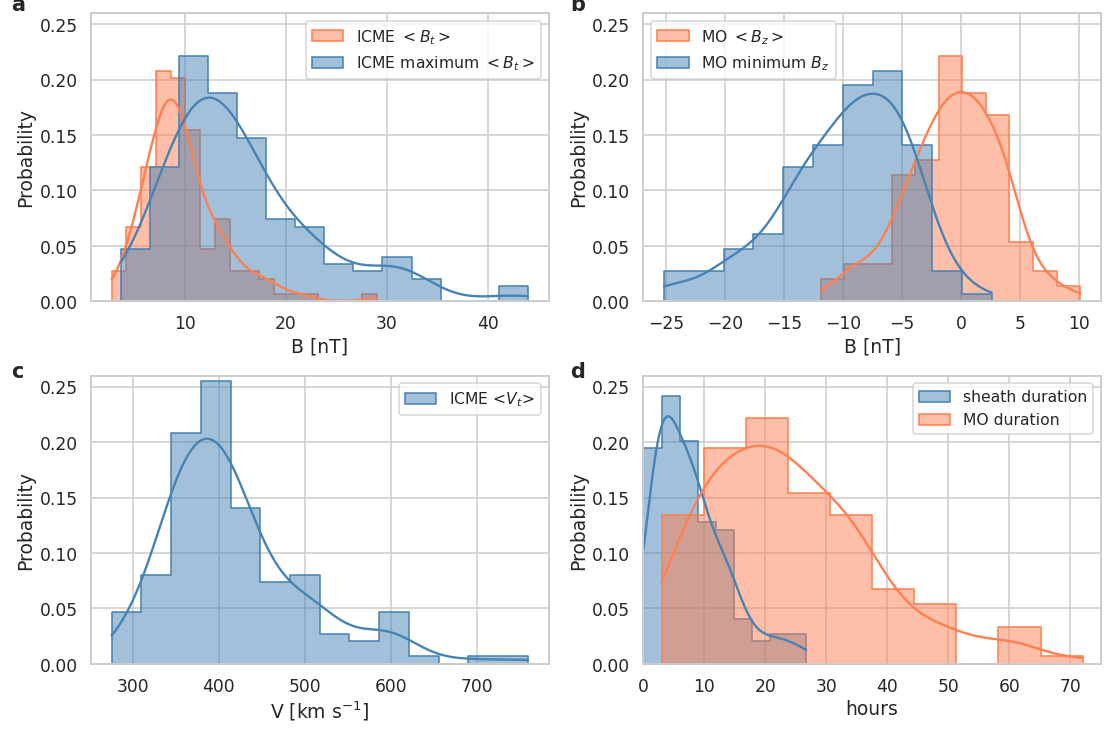

In [27]:
#make distribution plots
#plt.figure(10,figsize=(12,5))
#sns.histplot(ic.mo_sc_heliodistance)

sns.set_context("talk")     
sns.set_style('whitegrid')

fig=plt.figure(figsize=(15,10),dpi=75)

fs=15
ax1 = plt.subplot(221) 
sns.histplot(ic.loc[n_iwinind,'icme_bmean'], label='ICME $<B_t>$',color='coral',alpha=0.5,kde=True,stat='probability',element='step')
sns.histplot(ic.loc[n_iwinind,'icme_bmax'], label='ICME maximum $<B_t>$',color='steelblue',kde=True,stat='probability', element='step')
ax1.set_xlabel('B [nT]')
ax1.set_ylim(0,0.26)
plt.legend(loc=1,fontsize=fs)

ax2 = plt.subplot(222) 
sns.histplot(ic.loc[n_iwinind,'mo_bzmean'],label='MO $<B_z>$',color='coral',alpha=0.5,kde=True,stat='probability', element='step')
sns.histplot(ic.loc[n_iwinind,'mo_bzmin'],label='MO minimum $B_z$ ',color='steelblue',kde=True,stat='probability', element='step')
ax2.set_xlabel('B [nT]')
#ax2.set_ylabel('')
ax2.set_ylim(0,0.26)
plt.legend(loc=2,fontsize=fs)

ax3 = plt.subplot(223) 
sns.histplot(ic.loc[n_iwinind,'icme_speed_mean'],label='ICME <$V_t$>',color='steelblue',kde=True,stat='probability', element='step')
ax3.set_xlabel('V [km s$^{-1}$]')
ax3.set_ylim(0,0.26)
plt.legend(loc=1,fontsize=fs)

ax6 = plt.subplot(224) 
sns.histplot(ic.loc[n_iwinind,'icme_duration']-ic.loc[n_iwinind,'mo_duration'],label='sheath duration',color='steelblue',kde=True,stat='probability', element='step')
sns.histplot(ic.loc[n_iwinind,'mo_duration'],label='MO duration',color='coral',kde=True,stat='probability', element='step')
ax6.set_xlabel('hours')
ax6.set_ylim(0,0.26)
ax6.set_xlim(0,75)
#ax6.set_ylabel('')
plt.legend(loc=1,fontsize=fs)

#ax4 = plt.subplot(234) 
#sns.histplot(ic.loc[n_iwinind,'mo_density_mean'],label='MO <$N_p$>',color='steelblue',kde=True,stat='probability', element='step')
#ax4.set_xlabel('N [ccm$^{-3}$]')#
#ax4.set_ylim(0,0.25)
#ax4.set_ylabel('')
#plt.legend(loc=1)


#ax5 = plt.subplot(235) 
#sns.histplot(ic.loc[n_iwinind,'mo_temperature_mean'],label='MO <$T_p$>',color='steelblue',kde=True,stat='probability', element='step')
#ax5.set_xlabel('hours')
#ax5.set_ylim(0,0.25)#
#ax5.set_ylabel('')
#plt.legend(loc=1)
#plt.tight_layout()


plt.tight_layout()

plt.annotate('a',[0.01,0.96],xycoords='figure fraction',fontsize=20,weight='bold')
plt.annotate('b',[0.507,0.96],xycoords='figure fraction',fontsize=20,weight='bold')
plt.annotate('c',[0.01,0.47],xycoords='figure fraction',fontsize=20,weight='bold')
plt.annotate('d',[0.507,0.47],xycoords='figure fraction',fontsize=20,weight='bold')


argv3 ='fig2_dist.pdf'
plt.savefig('mfr_plots/' + argv3)
argv3 ='fig2_dist.png'
plt.savefig('mfr_plots/' + argv3)

In [28]:
# Set time window for features in hours
feature_hours = 4 #10

# Decide if you want to include the sheath region. 
use_sheath = True

if use_sheath:
    print("Option 1: Use MFR and sheath data for features")
    event_start = icme_start_time_num
else:
    print("Option 2: Use MFR and no sheath data for features")
    event_start = mo_start_time_num

# Define end of the event time window
event_end = mo_start_time_num + feature_hours / 24.0
      
# Define timing window of labels
label_start = mo_start_time_num
label_end = mo_end_time_num

Option 1: Use MFR and sheath data for features


In [29]:
# Compute mean, max and std-dev in feature time window
def get_feature(sc_time, start_time, end_time, sc_ind, sc_feature):
    feature_mean = np.zeros(np.size(sc_ind))
    feature_max = np.zeros(np.size(sc_ind))
    feature_std = np.zeros(np.size(sc_ind))
    feature_min = np.zeros(np.size(sc_ind))
    feature_cv  = np.zeros(np.size(sc_ind))
    feature_minmax = np.zeros(np.size(sc_ind))
    
    for p in np.arange(0, np.size(sc_ind)):
        time_slice = np.where(np.logical_and(sc_time > start_time[sc_ind[p]], sc_time < end_time[sc_ind[p]]))
        feature_slice = sc_feature[time_slice]
        feature_mean[p] = np.nanmean(feature_slice)
        feature_std[p] = np.nanstd(feature_slice)
        
        # Compute coefficient of variation (CV)
        feature_cv[p] = feature_std[p]/np.abs(feature_mean[p])
        
        feature_temp = feature_slice[np.isfinite(feature_slice)]
        try:
            feature_max[p] = np.max(feature_temp)
            feature_min[p] = np.min(feature_temp)
            feature_minmax[p] = feature_min[p]/feature_max[p]
        except ValueError:  # raised if `y` is empty.
            pass

    return feature_mean, feature_max, feature_std, feature_min, feature_cv, feature_minmax

# Compute either 'max' or 'mean' of total magnetic field in label time window
def get_label(sc_time, start_time, end_time, sc_ind, sc_label, label_type="max"):
    label_mean = np.zeros(np.size(sc_ind))
    label_max = np.zeros(np.size(sc_ind))
    label_min = np.zeros(np.size(sc_ind))

    for p in np.arange(0, np.size(sc_ind)):
        time_slice = np.where(np.logical_and(sc_time > start_time[sc_ind[p]], sc_time < end_time[sc_ind[p]]))
        label_slice = sc_label[time_slice]
        if len(label_slice) == 0:
            label_max[p] = np.nan
            label_min[p] = np.nan
            label_mean[p] = np.nan
        else:
            label_max[p] = np.nanmax(label_slice)
            label_min[p] = np.min([np.nanmin(label_slice), 0])
            label_mean[p] = np.nanmean(label_slice)
            
    if label_type == 'max':
        return label_max
    elif label_type == 'min':
        return label_min
    elif label_type == 'mean':
        return label_mean


In [113]:

# Compute either 'max' or 'mean' of total magnetic field in label time window
target_type = 'min'

# List of physical properties
variable_list = ['bx', 'by', 'bz', 'bt', 'vt','np','tp']


# If file doesn't exist, create it, otherwise load it
if not os.path.exists("mfr_predict/bz_fh{:.0f}_sta_features.p".format(feature_hours)):
    start_time = time.time()
    print("Option 1: Compute features...")

    # Wind features
    dwin = {}
    for variable in variable_list:
        all_var_features = get_feature(win['time'], event_start, event_end, n_iwinind, win[variable])
        dwin['mean('+variable+')'] = all_var_features[0]
        dwin['max('+variable+')'] = all_var_features[1]
        dwin['std('+variable+')'] = all_var_features[2]
        dwin['min('+variable+')'] = all_var_features[3]
        dwin['cv('+variable+')'] = all_var_features[4]
        dwin['minmax('+variable+')'] = all_var_features[5]

    # Wind labels
    label_btotmean = get_label(win['time'], label_start, label_end, n_iwinind, win['bz'], label_type=target_type)
    dwin['Target'] = label_btotmean
    
    # Create dataframe
    dfwin = pd.DataFrame(data=dwin)
    pickle.dump(dfwin, open(os.path.join(mfrdir, 'bz_fh{:.0f}_'.format(feature_hours) + savepath_win), "wb"))
    
    # STEREO-A features
    dsta = {}
    for variable in variable_list:
        all_var_features = get_feature(sta['time'], event_start, event_end, 
                                       n_istaind, sta[variable])
        dsta['mean('+variable+')'] = all_var_features[0]
        dsta['max('+variable+')'] = all_var_features[1]
        dsta['std('+variable+')'] = all_var_features[2]
        dsta['min('+variable+')'] = all_var_features[3]
        dsta['cv('+variable+')'] = all_var_features[4]
        dsta['minmax('+variable+')'] = all_var_features[5]

    # STEREO-A labels
    label_btotmean = get_label(sta['time'], label_start, label_end, n_istaind, sta['bz'], label_type=target_type)
    dsta['Target'] = label_btotmean
    
    # Create dateframe
    dfsta = pd.DataFrame(data=dsta)
    pickle.dump(dfsta, open(os.path.join(mfrdir, 'bz_fh{:.0f}_'.format(feature_hours) + savepath_sta), "wb"))
    
    # STEREO-B features
    dstb = {}
    for variable in variable_list:
        all_var_features = get_feature(stb['time'], event_start, event_end, 
                                       n_istbind, stb[variable])
        dstb['mean('+variable+')'] = all_var_features[0]
        dstb['max('+variable+')'] = all_var_features[1]
        dstb['std('+variable+')'] = all_var_features[2]
        dstb['min('+variable+')'] = all_var_features[3]
        dstb['cv('+variable+')'] = all_var_features[4]
        dstb['minmax('+variable+')'] = all_var_features[5]

    # STEREO-B labels
    label_btotmean = get_label(stb['time'], label_start, label_end, n_istbind, stb['bz'], label_type=target_type)
    dstb['Target'] = label_btotmean
    
    # Create dataframe
    dfstb = pd.DataFrame(data=dstb)
    pickle.dump(dfstb, open(os.path.join(mfrdir, 'bz_fh{:.0f}_'.format(feature_hours) + savepath_stb), "wb"))
    print("Option 1: Computation of data frame for Wind, STEREO-A, and STEREO-B completed")   
    end_time = time.time()
    print("Computation of features took {:.1f} minutes.".format((end_time - start_time)/60.))
else:
    print("Option 2: Loading existing data frames...")
    dfwin = pickle.load(open(os.path.join(mfrdir, 'bz_fh{:.0f}_'.format(feature_hours) + savepath_win), "rb"))
    dfsta = pickle.load(open(os.path.join(mfrdir, 'bz_fh{:.0f}_'.format(feature_hours) + savepath_sta), "rb"))
    dfstb = pickle.load(open(os.path.join(mfrdir, 'bz_fh{:.0f}_'.format(feature_hours) + savepath_stb), "rb"))
    print("Option 2: Loading existing data frame completed")

Option 2: Loading existing data frames...
Option 2: Loading existing data frame completed


In [114]:
# Events before tidying up
len_dfwin_nans = len(dfwin)
len_dfsta_nans = len(dfsta)
len_dfstb_nans = len(dfstb)

# Remove NaN's in data frames
dfwin = dfwin.dropna()
dfsta = dfsta.dropna()
dfstb = dfstb.dropna()

print("{} nans removed from WIND data".format(len_dfwin_nans-len(dfwin)))
print("{} nans removed from STEREO-A data".format(len_dfsta_nans-len(dfsta)))
print("{} nans removed from STEREO-B data".format(len_dfstb_nans-len(dfstb)))
print("Total number of events left:  ", len(dfwin)+len(dfsta)+len(dfstb))

0 nans removed from WIND data
12 nans removed from STEREO-A data
2 nans removed from STEREO-B data
Total number of events left:   348


## Machine learning

In [115]:
# Testing data size in percent
test_size = 0.3

# Split into training and testing data
win_train, win_test = train_test_split(dfwin, test_size=test_size, random_state=42)
sta_train, sta_test = train_test_split(dfsta, test_size=test_size, random_state=42)
stb_train, stb_test = train_test_split(dfstb, test_size=test_size, random_state=42)

# Combine spacecraft datasets
train = pd.concat([win_train, sta_train, stb_train])
test = pd.concat([win_test, sta_test, stb_test])

# Save the index of the events, as appearing in the data frames, to a numpy array
win_train_ind = win_train.index.to_numpy()
win_test_ind  = win_test.index.to_numpy()
sta_train_ind = sta_train.index.to_numpy()
sta_test_ind  = sta_test.index.to_numpy()
stb_train_ind = stb_train.index.to_numpy()
stb_test_ind  = stb_test.index.to_numpy()

# Calculate indices for training and testing data frame
train_ind = train.index.to_numpy()
test_ind = test.index.to_numpy()

# Some useful stuff:
# train.info()
# train.describe()

In [116]:
# Select features
use_features = list(train.columns)
use_features.remove('Target')

# Bring data into shape for machine learning models
if len(use_features) == 1:
    X_train = np.array(train[use_features]).reshape(-1, 1)
    X_test = np.array(test[use_features]).reshape(-1, 1)
else:
    X_train = np.array(train[use_features])
    X_test = np.array(test[use_features])
    
y_train = np.array(train['Target']).reshape(-1, 1)
y_test = np.array(test['Target']).reshape(-1, 1)

# Use pickle to save training and testing data
fname = os.path.join(mfrdir, 'fh{:.0f}_train_test_data.p'.format(feature_hours))
pickle.dump([n_iwinind, n_istaind, n_istbind, 
             win_train_ind, win_test_ind, 
             sta_train_ind, sta_test_ind, 
             stb_train_ind, stb_test_ind, 
             train_ind, test_ind, 
             X_train, X_test, y_train, y_test, 
             feature_hours], open(fname, 'wb'))

In [117]:
# Define machine learning models
def get_models(models=dict()):
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    models['rfr'] = RandomForestRegressor()
    models['gbr'] = GradientBoostingRegressor()
    return models

# Fit model, evaluate it and get scores
def sklearn_predict(model, X, y):
    # fit the model
    model.fit(X, y)
    # prediction
    y_predict = model.predict(X)
    score, mean_score, std_score = evaluate_forecast(model, X, y, y_predict)
    return score, mean_score, std_score, y_predict

# Define scores
def evaluate_forecast(model, X, y, y_predict):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    score = np.sqrt(-scores)
    mean_score = score.mean()  # root mean squared error
    std_score = score.std()
    return score, mean_score, std_score

In [118]:
# Use pickle to load training and testing data
savepath_traintest ='fh{:.0f}_train_test_data.p'.format(feature_hours)
fname = 'mfr_predict/' + savepath_traintest
[n_iwinind, n_istaind, n_istbind, win_train_ind, win_test_ind, sta_train_ind, sta_test_ind, 
     stb_train_ind, stb_test_ind, train_ind, test_ind, 
     X_train, X_test, y_train, y_test, feature_hours] = pickle.load(open(fname, 'rb'))

# Get different machine learning models
models = get_models()

mean_score = np.zeros(len(models))
std_score = np.zeros(len(models))
imod = 0

print("{:<10}{:<6}{:<6}".format("Model", "PCC", "MAE"))
for name, model in models.items():
    # fit model, evaluate and get scores
    score, mean_score[imod], std_score[imod], y_predict = sklearn_predict(model, X_train, y_train)
    # summarize scores
    ppmc = scipy.stats.pearsonr(np.squeeze(y_train), np.squeeze(y_predict))[0]
    mae = mean_absolute_error(np.squeeze(y_train), np.squeeze(y_predict))
    print("{:<10}{:6.2f}{:6.2f}".format(name, ppmc, mae))

Model     PCC   MAE   
lr          0.87  2.48
lasso       0.83  2.87
ridge       0.87  2.48
en          0.84  2.76
rfr         0.98  1.22
gbr         0.99  0.86


In [119]:
# Validate machine learning model on test data
print("{:<10}{:<6}{:<6}".format("Model", "PCC", "RMSE"))
for name, model in models.items():
    y_pred1 = models[name].predict(X_test)
    mae1 = mean_absolute_error(np.squeeze(y_test), np.squeeze(y_pred1))
    cc1 = scipy.stats.pearsonr(np.squeeze(y_test), np.squeeze(y_pred1))[0]
    print("{:<10}{:6.2f}{:6.2f}".format(name, cc1, mae1))

Model     PCC   RMSE  
lr          0.33  4.80
lasso       0.70  3.65
ridge       0.31  4.85
en          0.72  3.58
rfr         0.67  3.21
gbr         0.63  3.25


In [120]:
#X_test
#y_test

## Deep learning


In [130]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.models import Sequential

import copy

from tensorflow.keras.layers.experimental import preprocessing

#X_train=X_train[:,0:30]

print('training data shape features ', X_train.shape)
print('training data shape labels', y_train.shape)


# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

#deep copy training data
X_train2=copy.deepcopy(X_train)
y_train2=copy.deepcopy(y_train)

# scale training data
X_train_norm = scaler.fit_transform(X_train2)
y_train_norm = scaler.fit_transform(y_train2)
# inverse transform: X_train_inverse = scaler.inverse_transform(X_train_norm)

#deep copy test data
X_test2=copy.deepcopy(X_test)
y_test2=copy.deepcopy(y_test)
X_test_norm = scaler.fit_transform(X_test2)
y_test_norm = scaler.fit_transform(y_test2)

input_shape = (X_train.shape[1],)
output_shape = y_train.shape[1]

training data shape features  (243, 42)
training data shape labels (243, 1)


<AxesSubplot:ylabel='Count'>

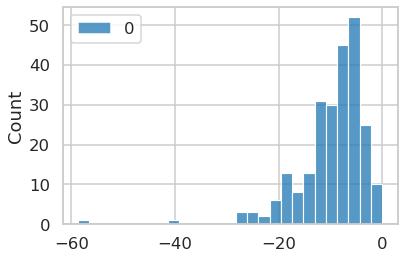

In [131]:
#sns.histplot(X_train[0,:])
#sns.pairplot(X_train)
sns.histplot(y_train)

In [158]:
dl_model= None
dl_model = Sequential(
    [
        Input(shape=input_shape),
        layers.Dense(50, activation="relu",kernel_initializer='normal'),
        layers.Dense(20, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(output_shape, activation='linear'),
    ]
)

dl_model.summary()
dl_model.compile(loss="MeanSquaredError", optimizer=tf.optimizers.Adam(learning_rate=0.1))#, metrics=["accuracy"])


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 50)                2150      
_________________________________________________________________
dense_37 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 84        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 5         
Total params: 3,259
Trainable params: 3,259
Non-trainable params: 0
_________________________________________________________________


In [159]:
%%time

dl_model.compile(loss="MeanSquaredError", optimizer=tf.optimizers.Adam(learning_rate=0.1))#, metrics=["accuracy"])

dl_model_hist=dl_model.fit(X_train_norm, y_train_norm, epochs=50, validation_split=0.3,verbose=0)   


#model.compile(loss="MeanSquaredError", optimizer="SGD"(lr=0.01, momentum=0.9))
#batch_size = 128
#model.fit(X_train, y_train, epochs=50,batch_size=batch_size, validation_split=0.1)#,verbose=0)   
#test_results = {}
#test_results['dl_model1'] = model.evaluate(X_train_norm,y_train_norm, verbose=1)

CPU times: user 34.3 s, sys: 3.01 s, total: 37.3 s
Wall time: 1.98 s


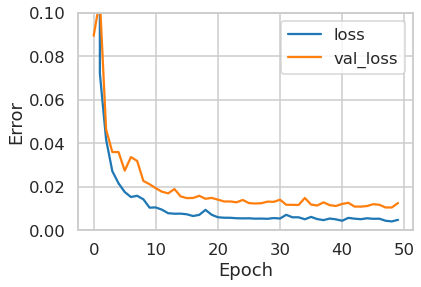

In [162]:
hist1 = pd.DataFrame(dl_model_hist.history)
hist1['epoch'] = dl_model_hist.epoch
hist1.tail()


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)


plot_loss(dl_model_hist)

Mean absolute error +/- std:  4.8 +/-  3.57



<AxesSubplot:ylabel='Count'>

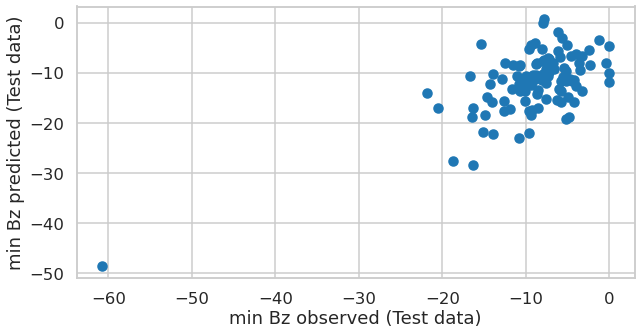

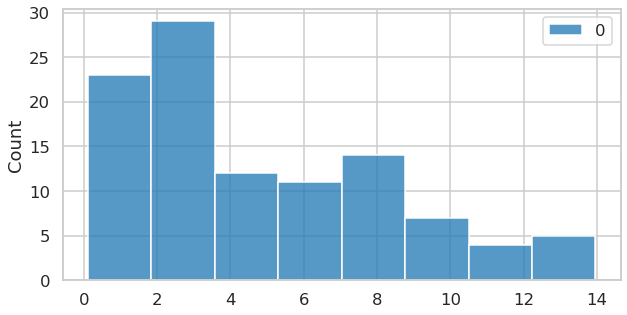

In [163]:
plt.figure(10,figsize=(10,5))

#use model
y_predict_norm = dl_model.predict(X_test_norm)
#inverse scaling
y_predict=scaler.inverse_transform(y_predict_norm)

plt.scatter(y_test, y_predict)
#plt.plot(x, y, color='k', label='Predictions')
plt.xlabel('min Bz observed (Test data)')
plt.ylabel('min Bz predicted (Test data)')
#plt.legend()
meanabs=np.round(np.mean(abs(y_test-y_predict)),1)
stdabs=np.round(np.std(abs(y_test-y_predict)),2)

print('Mean absolute error +/- std: ',meanabs, '+/- ', stdabs)
print()


plt.figure(11,figsize=(10,5))
sns.histplot(data=abs(y_test-y_predict))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 105

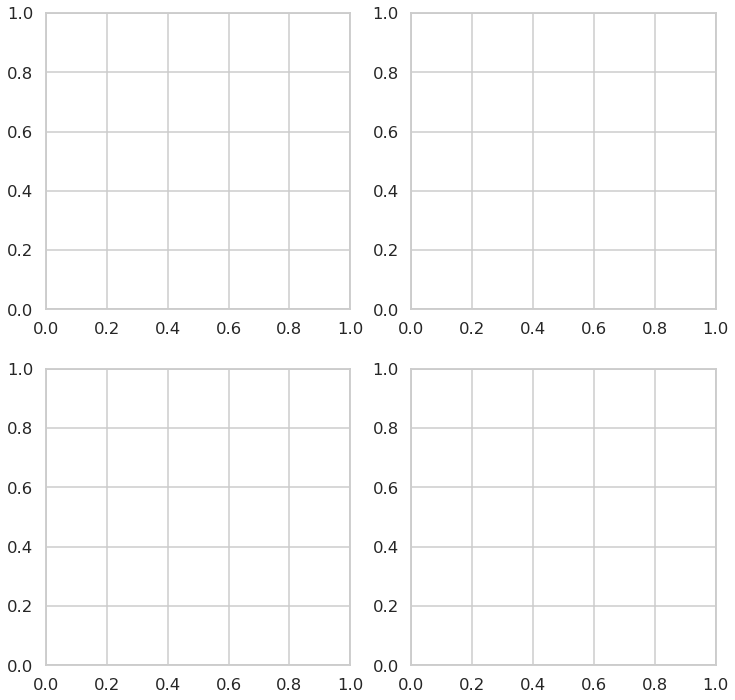

In [44]:
# Create scatter density plots for different models
from scipy.stats import gaussian_kde

fig, [(ax1,ax2),(ax3,ax4)] = plt.subplots(2, 2,figsize=(12,12))

x = y_test
y = y_pred1
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax1.scatter(x, y, c=z, s=50, edgecolor='')
ax1.set_xlim([2,-25])
ax1.set_ylim([2,-25])
ax1.set_aspect('equal', 'box')
ax1.text(-21, -2, 'LR', fontsize=18)
ax1.set_xlabel('min($B_{\mathrm{z}}$) observed [nT]', fontsize=14)
ax1.set_ylabel('min($B_{\mathrm{z}}$) predicted [nT]', fontsize=14)
ax1.plot([-100, 100],[-100, 100], ls=":")

x = y_test
y = y_pred2
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax2.scatter(x, y, c=z, s=50, edgecolor='')
ax2.set_xlim([2,-25])
ax2.set_ylim([2,-25])
ax2.set_aspect('equal', 'box')
ax2.text(-21, -2, 'RFR', fontsize=18)
ax2.set_xlabel('min($B_{\mathrm{z}}$) observed [nT]', fontsize=14)
ax2.set_ylabel('min($B_{\mathrm{z}}$) predicted [nT]', fontsize=14)
ax2.plot([-100, 100],[-100,100], ls=":")

x = y_test
y = y_pred3
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax3.plot([-100, 100],[-100, 100], ls=":")
ax3.scatter(x, y, c=z, s=50, edgecolor='')
ax3.set_xlim([2,-25])
ax3.set_ylim([2,-25])
ax3.set_aspect('equal', 'box')
ax3.text(-21, -2, 'GBR', fontsize=18)
ax3.set_xlabel('min($B_{\mathrm{z}}$) observed [nT]', fontsize=14)
ax3.set_ylabel('min($B_{\mathrm{z}}$) predicted [nT]', fontsize=14)
ax4.boxplot([np.abs(y_test-y_pred1),np.abs(y_test-y_pred2),np.abs(y_test-y_pred3)])
ax4.set_ylim([-1,25])

plt.xticks([1, 2, 3], ['LR', 'RFR', 'GBR'], fontsize=14)
asp = np.diff(ax4.get_xlim())[0] / np.diff(ax4.get_ylim())[0]
ax4.set_aspect(asp)
ax4.set_ylabel('Absolute Errors [nT]', fontsize=14)


plt.subplots_adjust(wspace=0.25)
for ax, ann in zip([ax1, ax2, ax3, ax4], ['a', 'b', 'c', 'd']):
    ax.text(.05, .9, ann, transform=ax.transAxes, fontsize=20, weight='bold')

argv3='scatter_plot_minbz_{}h.pdf'.format(feature_hours)  
plt.savefig('plots/' + argv3, bbox_inches='tight')
plt.show()